# Multivariate ARIMA Forcasting On Magic: the Gathering, Median Card Prices
An analysis of the effect of MTG tournaments on online card prices.
## - Christopher W. Evans, UMass Amherst Undergraduate


A note on the data: 
Surprising, at the time of this analysis, the complete dataset of pricing history does not exist. The tools and collected all the data for this analysis was built by myself (Chris Evans). The data for this project is private. Eventually I will release the scrapers and the data csv's when I know for sure that this is not easily monetizable.

### Functions to help with analysis
I won't go over the details of how each function works but I will outline the functionality and use cases.

In [1]:
import os, csv
import pandas as pd
import json

example_card = './data/war-of-the-spark/teferi,-time-raveler/'

### card data is stored within folder so this is used to convert the real name into folder-name.
### eg, Teferi, Time Raveler = teferi,-time-raveler
def convert_name(name):
    return name.replace('/', 'out').replace(" ", "-").lower()
    pass


### converts unix timestamp into datetime
def dateparse(time_unix):
    return datetime.utcfromtimestamp(int(time_unix)/1000).strftime('%Y-%m-%d %H:%M:%S')

### loads all the occurance data into a DataFrame
def load_occurance_data(path=r'./data/'):
    csv_path = os.path.join(path, 'occurance_data-1.csv')
    return pd.read_csv(csv_path,parse_dates=True,date_parser=dateparse)

### constructs a pandas.Dataframe from a .csv file which contains all of the historical pricing data
def load_card_data(card_path=example_card):
    csv_path = os.path.join(card_path, 'historic.csv')
    card = pd.read_csv(csv_path,parse_dates=['datetime'])
    card.loc[:,'date_unix'] = card['date_unix']/1000
    card.loc[:,'datetime'] = pd.to_datetime(card['datetime'])
    card.set_index('datetime')
    card.loc[:,'d_price_dollars'] = card['price_dollars'].diff()
    return card

### constructs a pandas.Dataframe containing all of the data contained on the card
### eg, rarity, name, etc
def load_manifest_data(card_path=example_card):
    csv_path = os.path.join(card_path, 'manifest.csv')
    data = None
    with open(csv_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        headers = next(reader, None)
        data = [r for r in reader]
    return data[0]


### constructs a pandas.Dataframe containing all of the occurance data of each card grouped by day. It is possible
### that there are more than one tournaments per day, but the analysis will only interval per day so that data must
### be grouped into one row

def load_occurances_grouped_date(path):
    card_manifest = load_manifest_data(path)
    occurances = load_occurance_data()
    card_occurances = occurances.loc[occurances['card']==card_manifest[0]]
    
    card_occurances.loc[:,'datetime'] = pd.to_datetime(card_occurances['date'])
    card_occurances.set_index('datetime')
    card_occurances.loc[:,'raw_per_decks'] = card_occurances['raw']/card_occurances['deck_nums']
    card_occurances.loc[:,'total_first'] = card_occurances['1st Place']
    
    card_occurances.loc[:,'scaled_placement'] = .5*(card_occurances['1st Place'] + card_occurances['2nd Place']) + .25*(card_occurances['3rd Place'] + card_occurances['4th Place']) + .13*(card_occurances['5th Place'] + card_occurances['6th Place'] + card_occurances['7th Place'] + card_occurances['8th Place'])
    
    
    card_occs_nums_only = card_occurances.drop('event', axis=1).drop('date_unix', axis=1).drop('card', axis=1)
    card_occs_stacked = card_occs_nums_only.groupby('datetime').sum().reset_index()
    

    card_occs_stacked.loc[:,'raw_rolling'] = card_occs_stacked['raw_per_decks'].rolling(window=14).mean()
    #card_occs_stacked.loc[:,'d_raw_rolling'] = card_occs_stacked['raw_rolling'].diff()
    #card_occs_stacked.loc[:,'d_raw_per_decks'] = card_occs_stacked['raw_per_decks'].diff()
    
    return card_occs_stacked

def load_tournament_dates(path='./data/tournies.json'):
    with open(path) as json_data:
        obj = json.load(json_data)
        array = []
        for key, item in obj.items():
            if item not in array:
                array.append(item)
        df = pd.DataFrame(array, columns=['tourny_dates'])
        df['tourny_dates'] = pd.to_datetime(df['tourny_dates'])
        df['date'] = df['tourny_dates']
        df.set_index('date', inplace=True)
        return(df)
    

In [2]:
import matplotlib.dates as mdates
from scipy import integrate
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

### A quality-of-life function to load data and show it all in one swing

def show_raw_and_prices(path):
    print(path.split('/')[-1])
    card = load_card_data(path)
    card_occurances = load_occurances_grouped_date(path)
    
    #plot data
    
    fig, ax = plt.subplots(figsize=(15,7))
    ax = card.plot(x='datetime', y='price_dollars', ax=ax)
    #ax = card.plot(x='datetime', y='d_price_dollars', ax=ax, style='--', color='blue')
    ax = card_occurances.plot(x='datetime', y='raw_per_decks', ax=ax, style='--', alpha=1)
    #ax = card_occurances.plot(x='datetime', y='scaled_placement', ax=ax, style=':', alpha=1, color='red')
    #ax = card_occurances.plot(x='datetime', y='total_first', ax=ax, style='.', alpha=.3, color='green')
    #ax = card_occurances.plot(x='datetime', y='2nd Place', ax=ax, style='.', alpha=.3, color='purple')
    #ax = card_occurances.plot(x='datetime', y='3rd Place', ax=ax, style='.', alpha=.3, color='blue')
    ax = card_occurances.plot(x='datetime', y='raw_rolling', ax=ax, style='-', alpha=1, color='red')
    #ax = card_occurances.plot(x='datetime', y='d_raw_per_decks', ax=ax, style=':', alpha=1, color='red')
    
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.grid()
    plt.gcf().autofmt_xdate()
    plt.show()

## Multivariance

Below is a graph of the two the main features that have been collected, the pricing history (Blue) and the occurances in tournaments (Orange and Red). I chose to add the rolling average of the occurance data (Red) because the occurance data is quite noisy and hard to read. 

As you can see, the occurance data seems somewhat correlated with the price of the card overtime. The question is, can we leverage it to predicts gains/losses in the future?

godless-shrine


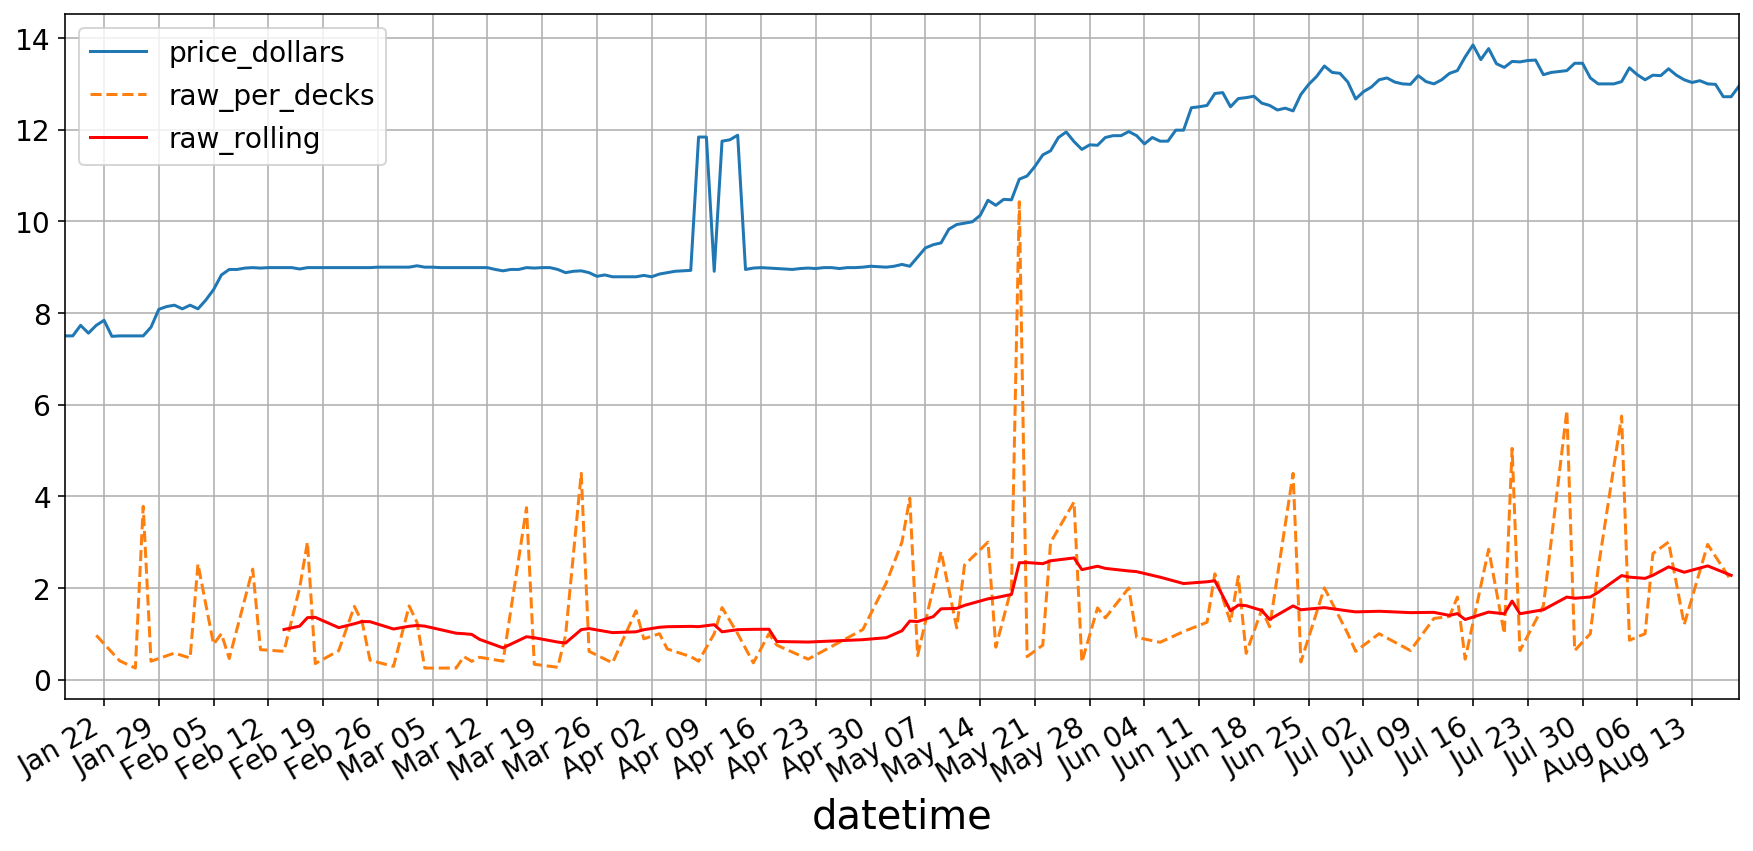

In [52]:
show_raw_and_prices('./data/ravnica-allegiance/godless-shrine')

## Forcasting Analysis

Firstly, we should load up the data on an example card to begin to outline the data prep process.

### Data Loading
Just to setup the graphing environment and do some basic imports

In [12]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

plt.ion()

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

Now we should pull all the data from csv's and merge the data into one useful DataFrame.

In [14]:
path = './data/guilds-of-ravnica/vraska,-golgari-queen'

card = load_card_data(path).drop('date_unix', axis=1)

card_occurances = load_occurances_grouped_date(path)
card_occurances_raw = card_occurances[['datetime', 'raw_per_decks']]

table  = pd.merge(card,
                 card_occurances_raw[['datetime', 'raw_per_decks']],
                 on='datetime', 
                 how='left')

Keep in mind that the initial analysis will be super simple. Later in this document I will explore using more features such as occurances in different formats and so on. For now I am using three features: 'price_dollars' (card prices over time), 'd_price_dollers' (differentiated price_dollars), and 'raw_per_decks' (the number of raw occurances in a tournament over the number of decks that make placements).

Here is what the table looks like now:

In [15]:
table.iloc[100:105, :]

,datetime,price_dollars,d_price_dollars,raw_per_decks
100,2019-01-05,6.00,-0.01,NaN
101,2019-01-06,6.00,0.00,0.125
102,2019-01-07,5.99,-0.01,NaN
103,2019-01-08,5.99,0.00,NaN
104,2019-01-09,5.99,0.00,NaN


### So why d_price_dollars?

This is pretty much the crux of the difference between VAR and ARIMA models. ARIMA stands for Auto Regression Integrated Moving Average. The differentiation is the 'Integrated' part. Think of it like this: price_dollars is the integral of d_price_dollars. 

The reason why is we want to make sure that we distil the data down to the simplest usable form while also the mainting the ability to develop new datapoints as time moves forward without overlaped featuredata. This means that all features must be 'stationary', or in more simple terms, the datapoint should not be related to the point that came before it. EG, the autocorrelation remains constant over time.

Here are some graphs of the autocorrelation.

*Note: Technically I am making an ARIMAX model or something, but I don't like tacking on new letters for each new feature so for now I am just going to call it an ARIMA model.*

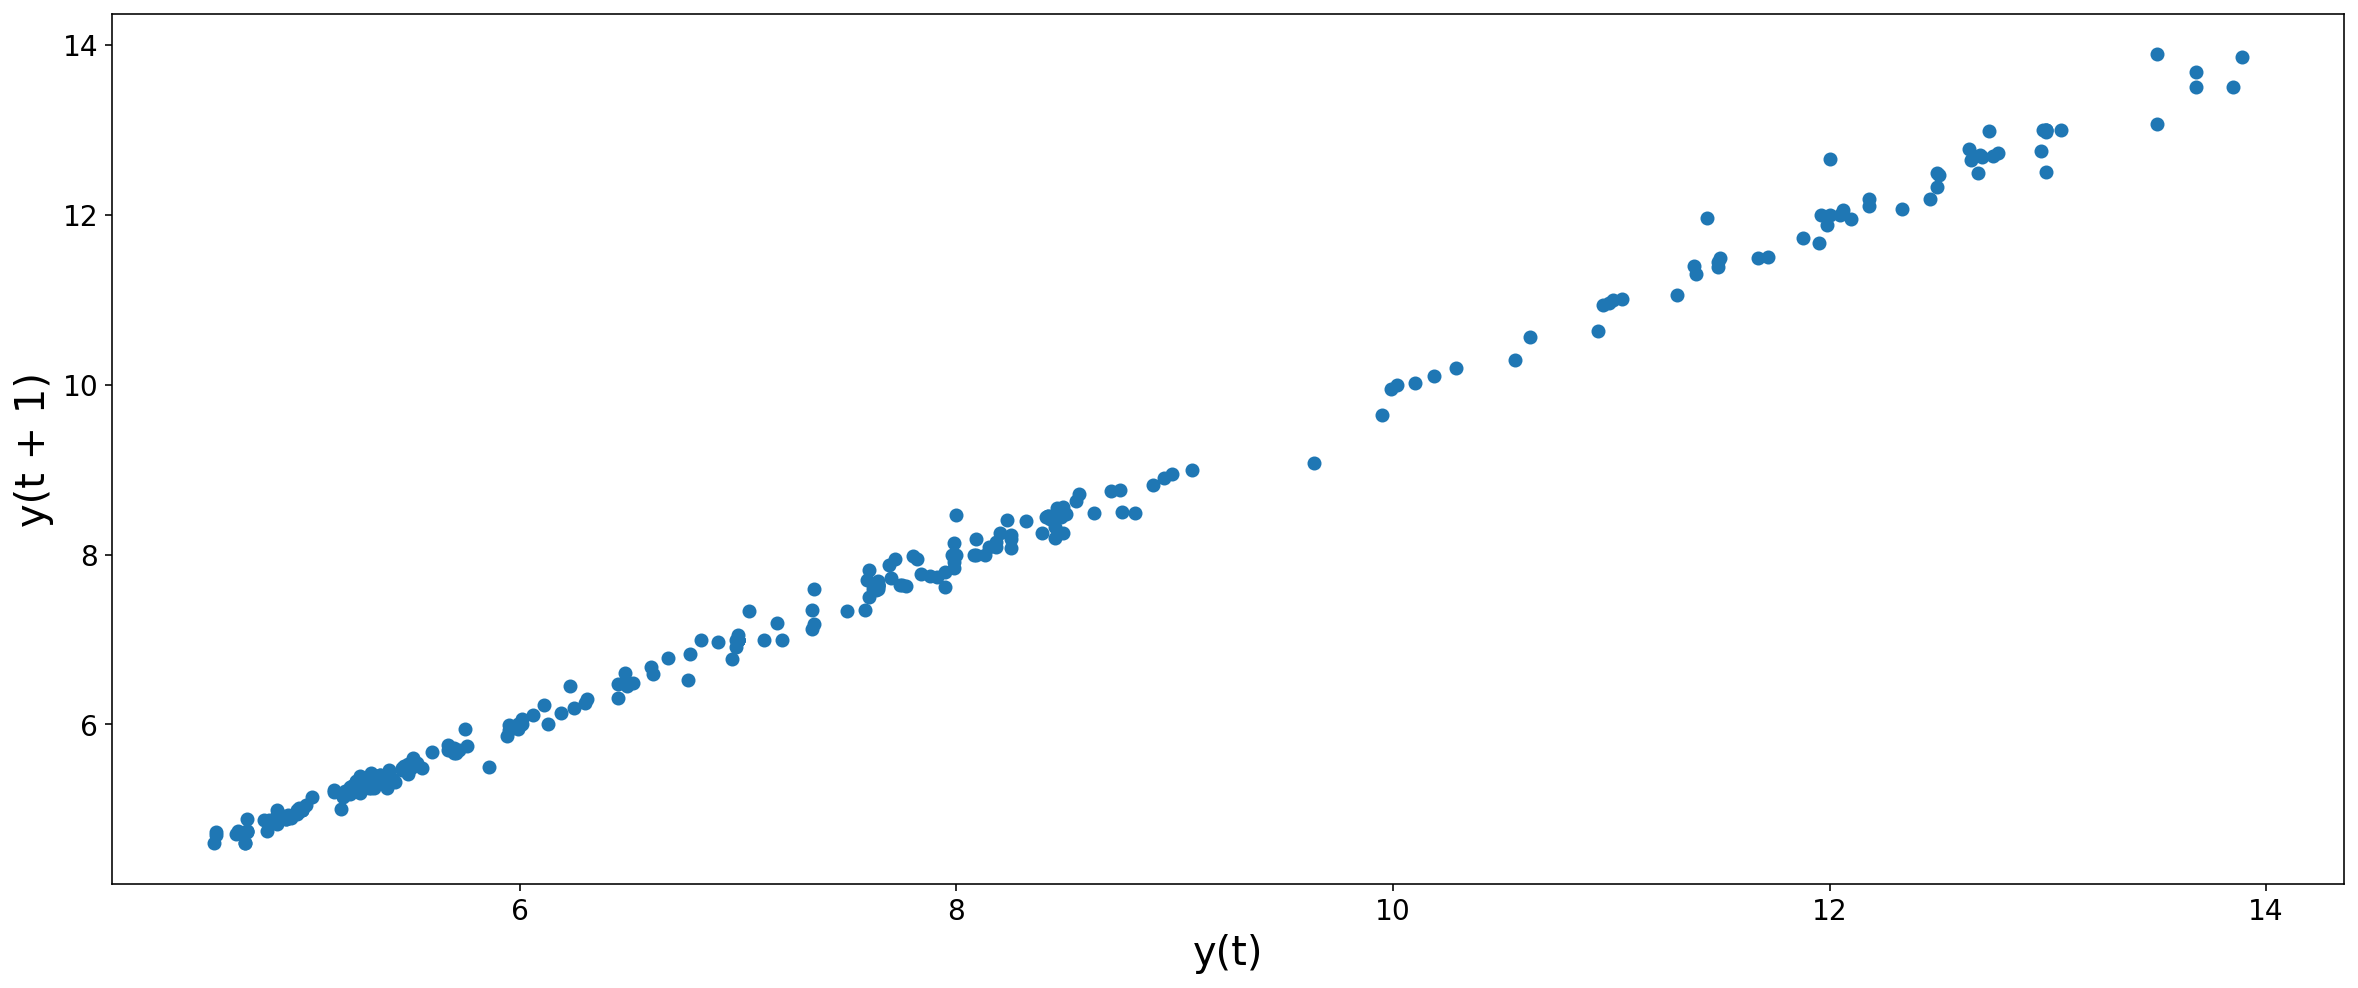

In [16]:
from pandas.plotting import lag_plot
lag_plot(table['price_dollars'], lag=1)

This Correlation pretty much speaks for itself. This graph shows that y(t) is a really good predictor of the value of y(t+1). Athough, this graph might lead us to believe that a presistence model would perform well. We don't want our model to fit this correlation.

It might not always be clear that features are correlated. Statsmodels Library actually provides a handy little grapher that shows you when you need to fix your autocorrelation.

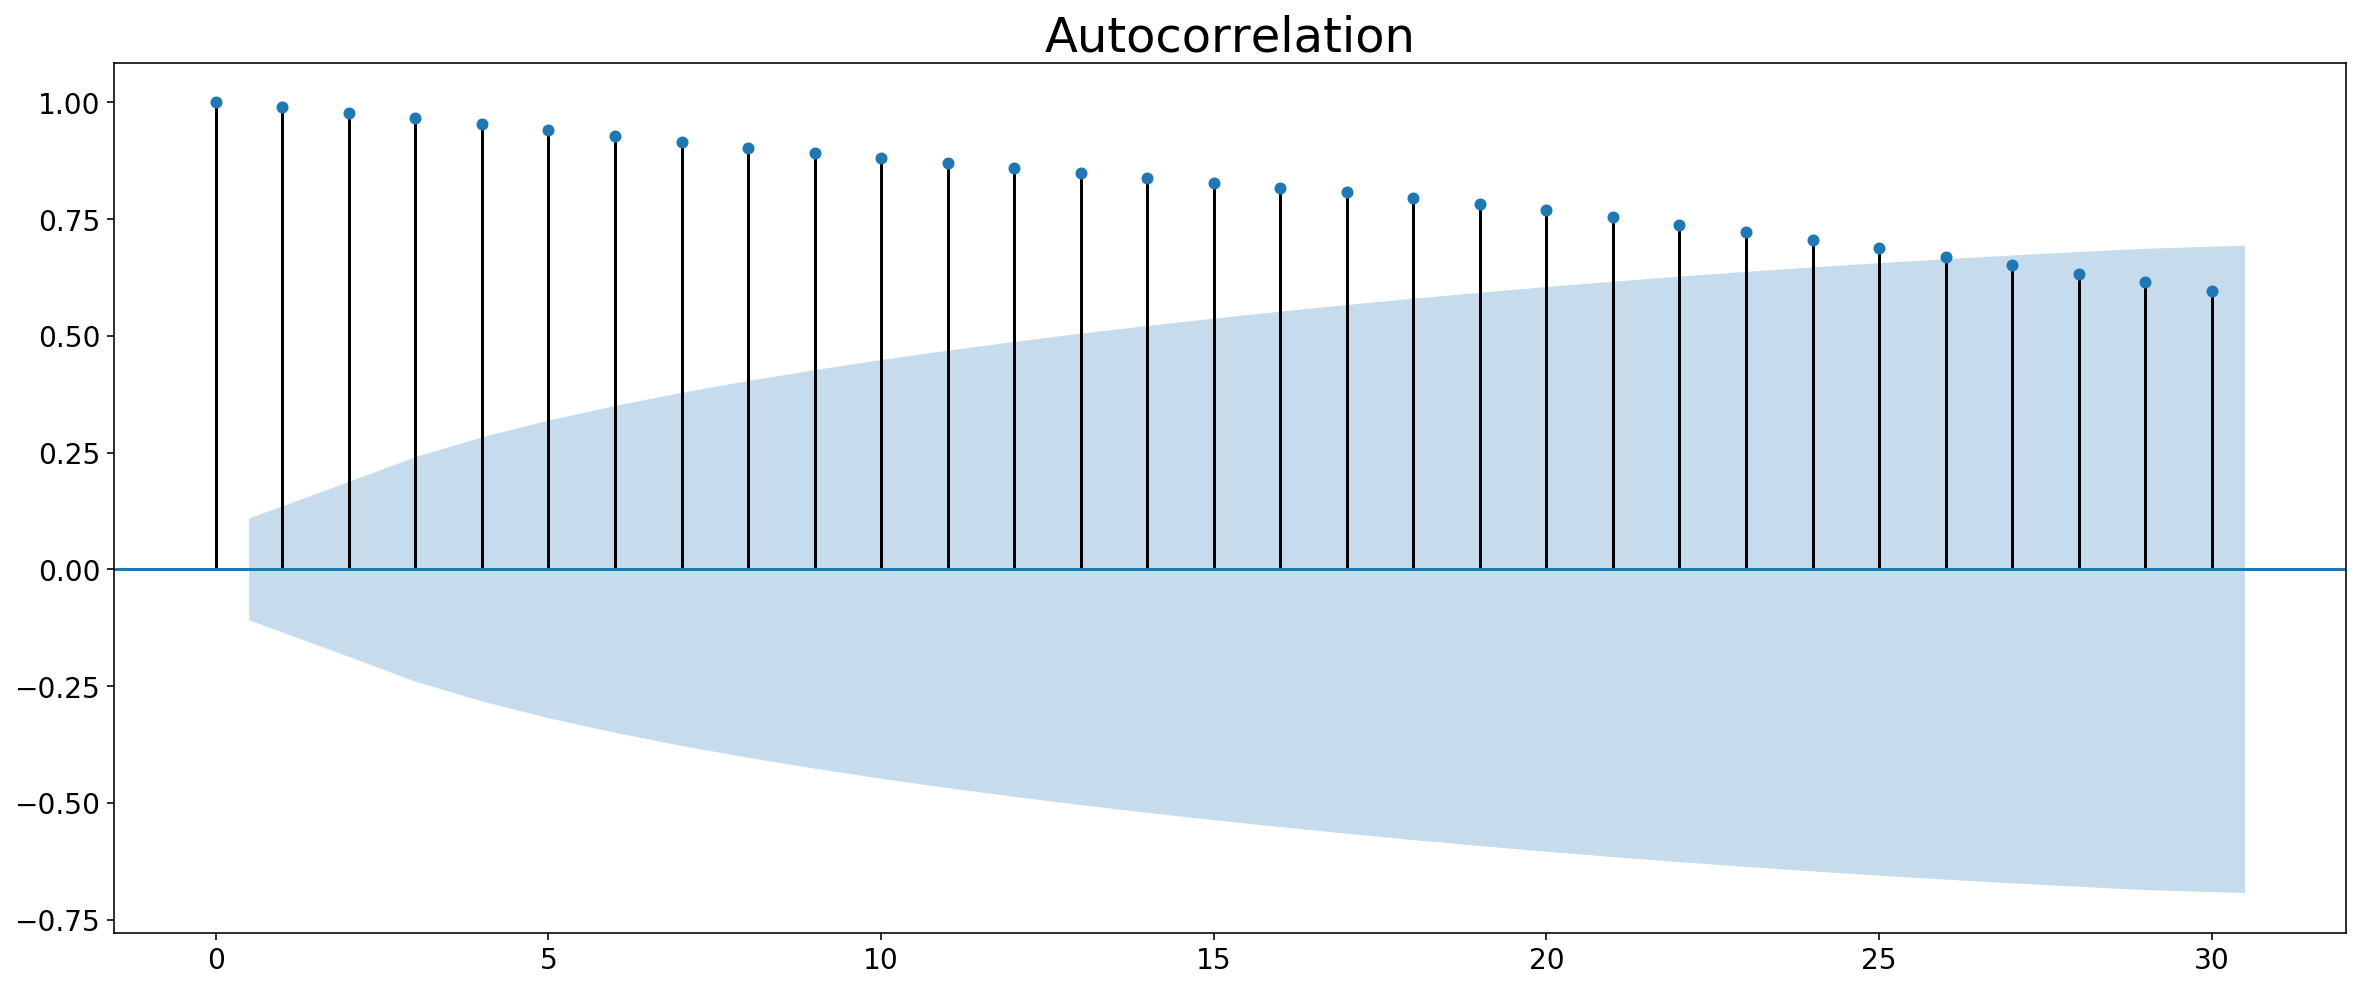

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(table['price_dollars'], lags=30)
plt.show()

Differentiating the data should solve this. While we are at it, we should probably reindex to make sure all datetimes are represented.

In [18]:
table.set_index('datetime', inplace=True)

idx = pd.date_range(table.index[0], table.index[-1])
table = table.reindex(idx, fill_value=None)
table['price_dollars'].fillna(method='ffill', inplace=True)
table.loc[:,'d_price_dollars'] = table['price_dollars'].diff()

Fortunately, the first derivative does the trick:

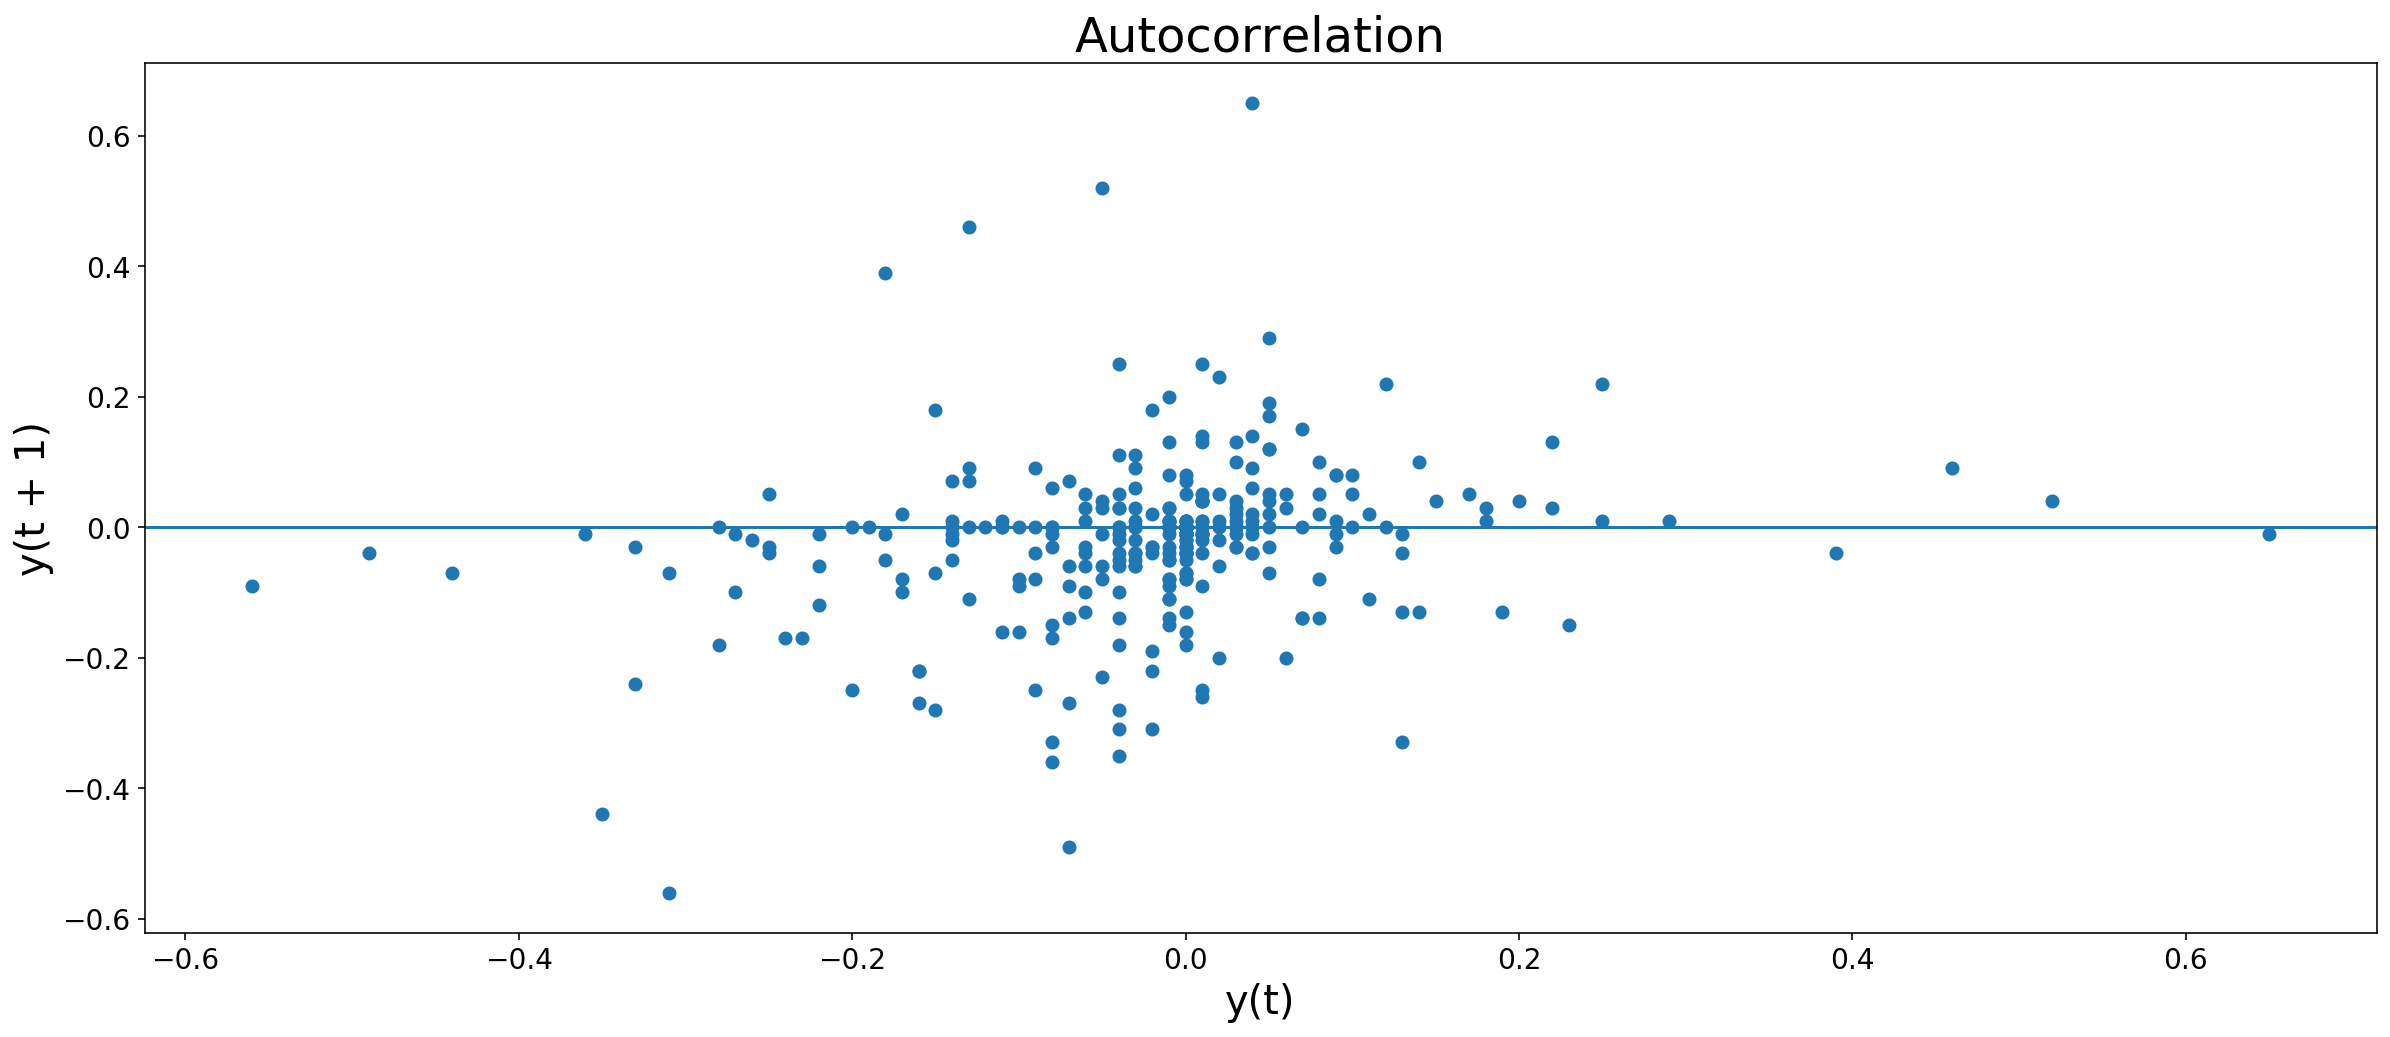

In [19]:
plot_acf(table['d_price_dollars'], lags=30)
lag_plot(table['d_price_dollars'], lag=1)
plt.show()

*I didn't differentiate the 'raw_per_decks' feature because in this particular card, it is so sparse. I checked the autocorrelation down the line. As I suspected, it was pretty low given the nature of MTG card game.*

### Data Prep

The next step is to make sure that the difference is made between there being no occurances and there being no tournamentes on that day. As of right now, both are marked as NaN, but will later be marked as either NaN or 0.

I did this by loading the dates from a json data file I collected. Then by joining the tables about the datetime index I was able to see which rows were associated with a tournament and which were not.

In [20]:
tourny_dates = load_tournament_dates(path='./data/tournies_standard_aug19-oct17.json')
example_full_table = pd.merge(table, tourny_dates, how='left', right_index=True, left_index=True)
pre_pipeline_df = example_full_table.copy()
pre_pipeline_df.head()

,price_dollars,d_price_dollars,raw_per_decks,tourny_dates
2018-09-27,13.68,NaN,NaN,2018-09-27
2018-09-28,13.68,0.00,NaN,NaT
2018-09-29,13.50,-0.18,NaN,NaT
2018-09-30,13.89,0.39,NaN,NaT
2018-10-01,13.85,-0.04,NaN,2018-10-01


The set the values accordingly and use the forward fill to complete the table. The ffill method is particularly good for this scenario given that if there was not a tournament on that day, then the last scheduled tournmement appears higher up in the viewing order.

In [21]:
for i in range(example_full_table.shape[0]):
    if not pd.isnull(example_full_table.iloc[i,3]) and pd.isnull(example_full_table.iloc[i,2]):
        example_full_table.iloc[i,2] = 0 

example_full_table = example_full_table.drop('tourny_dates', axis=1)
example_full_table.fillna(method='ffill', inplace=True)

The next cell is a function that I am calling 'horizonize' which is based off of Ethan Rosenthal's blog [link here](https://www.ethanrosenthal.com/2019/02/18/time-series-for-scikit-learn-people-part3/)

*Ethan Rosenthal actually made a whole library to help with this sort of analysis using scikit-learn called [skits](https://github.com/EthanRosenthal/skits). Unfortunately, I had trouble findind docs that I could understand so I just reinvented the wheel on this one.*


In [22]:
import pandas as pd

def horizonize(array, window=6, col='', index=[]):
    cols = []
    for i in range(window):
        cols.append(col+'_t-' + str(i))
        
    df = pd.DataFrame(columns=cols)
    for i in range(0, len(array)):
        if i<window:
            df.loc[i] = [array[i-j] for j in range(i+1)] + [None for k in range(1, window-i)]
        else:
            df.loc[i] = [array[i-j] for j in range(window)]
            
    if len(index) > 0:
        df.set_index(index, inplace=True)
    return(df)


Here I just add two rolling averages to the DataFrame because those help out alot when predicting the integral constant. The model we will train would have a hell of a time trying to predict the dollar value of the card based soley off of the way that it has changed over time. There needs to be some sort of reference to fill in where the derivative falls off, and that is the rolling average feature. It is important to shift the rolling window as to not bleed predicting data in to the featuredata set.

In [23]:
example_full_table.loc[:,'raw_rolling'] = example_full_table['raw_per_decks'].rolling(window=5).mean()
example_full_table.loc[:,'price_dollars_rolling'] = example_full_table['price_dollars'].shift().rolling(window=5).mean()

The full table thus far plotted. It is a bit busy, but should be enough to understand where we are at right now.

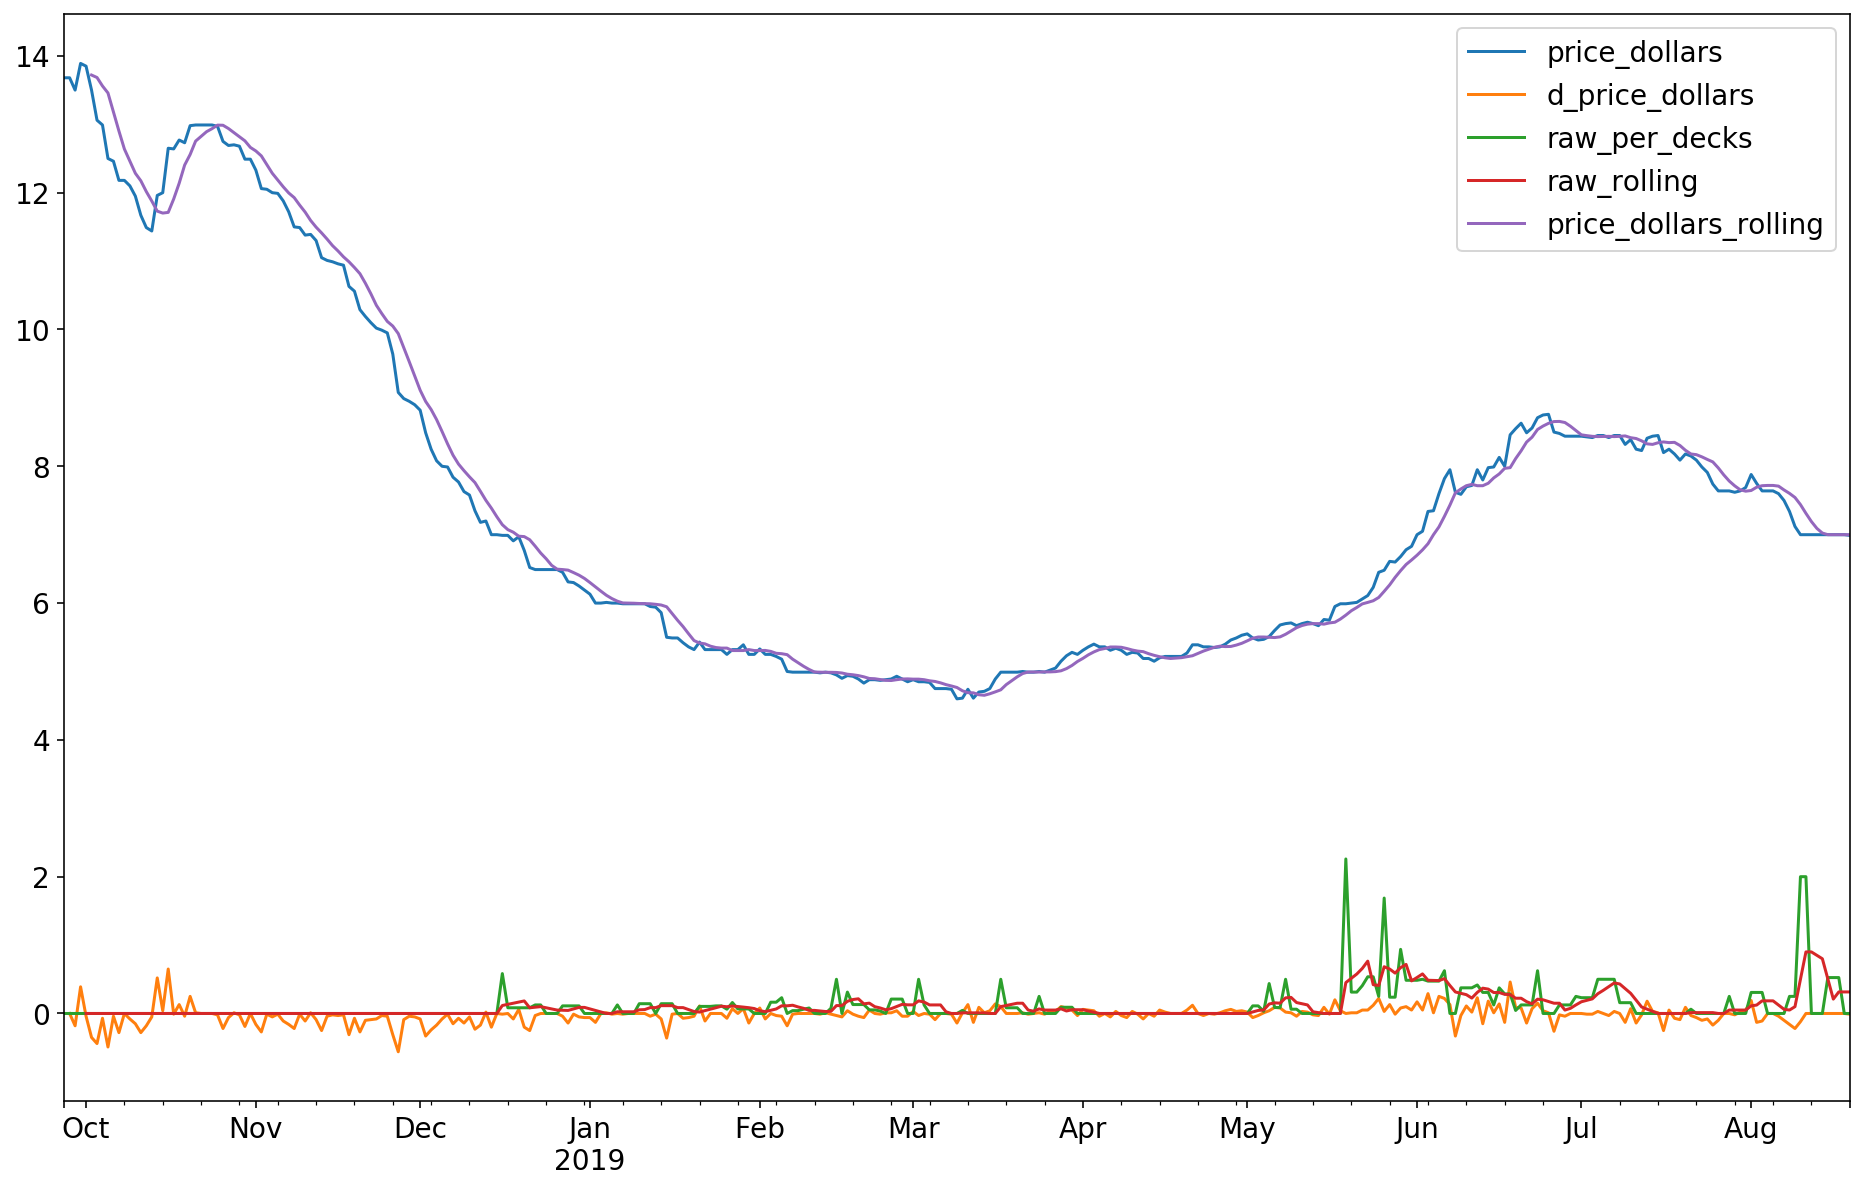

In [24]:
example_full_table.plot(figsize=(16,10))

Just a quick backfill to keep the table the same size after the rolling averages.

In [25]:
example_full_table.fillna(method='bfill', inplace=True)
example_full_table.head()

,price_dollars,d_price_dollars,raw_per_decks,raw_rolling,price_dollars_rolling
2018-09-27,13.68,0.00,0.0,0.0,13.72
2018-09-28,13.68,0.00,0.0,0.0,13.72
2018-09-29,13.50,-0.18,0.0,0.0,13.72
2018-09-30,13.89,0.39,0.0,0.0,13.72
2018-10-01,13.85,-0.04,0.0,0.0,13.72


Here is where horizonize gets implemented. What it does is effectively make a feature for each lag interval so that we can predict off of a small sub-vector of the whole feature. See for yourself:

In [26]:
hdpd = horizonize(example_full_table['d_price_dollars'].values,
                  col='d_pd', window =4, 
                  index=example_full_table.index)

hraw = horizonize(example_full_table['raw_per_decks'].values, 
                  col='raw',window=4,
                  index=example_full_table.index)

hraw = hraw.drop('raw_t-0', axis=1)
hdpd = hdpd.drop('d_pd_t-0', axis=1)
prepared_data = pd.concat([hraw, hdpd, example_full_table['price_dollars_rolling'], 
                           example_full_table['price_dollars']], axis=1).dropna(axis=0)
prepared_data.head(10)

,raw_t-1,raw_t-2,raw_t-3,d_pd_t-1,d_pd_t-2,d_pd_t-3,price_dollars_rolling,price_dollars
2018-09-30,0.0,0.0,0.0,-0.18,0.00,0.00,13.720,13.89
2018-10-01,0.0,0.0,0.0,0.39,-0.18,0.00,13.720,13.85
2018-10-02,0.0,0.0,0.0,-0.04,0.39,-0.18,13.720,13.50
2018-10-03,0.0,0.0,0.0,-0.35,-0.04,0.39,13.684,13.06
2018-10-04,0.0,0.0,0.0,-0.44,-0.35,-0.04,13.560,12.99
2018-10-05,0.0,0.0,0.0,-0.07,-0.44,-0.35,13.458,12.50
2018-10-06,0.0,0.0,0.0,-0.49,-0.07,-0.44,13.180,12.46
2018-10-07,0.0,0.0,0.0,-0.04,-0.49,-0.07,12.902,12.18
2018-10-08,0.0,0.0,0.0,-0.28,-0.04,-0.49,12.638,12.18
2018-10-09,0.0,0.0,0.0,0.00,-0.28,-0.04,12.462,12.10


*Note: It is very important to drop the t-0 columns because that would bleed the values we are trying to predict into the featuredata.*

### Prediction with Linear Regressor

Separating the y vector from the features.

In [27]:
X, y = prepared_data.copy().drop('price_dollars', axis=1), prepared_data['price_dollars']

Just picking an arbitrary split point. Keep in mind that the later the split point the better the training will be.

In [28]:
split_idx = 200
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

Might as well fit two models side by side

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

tree_reg = DecisionTreeRegressor(random_state=42)
lin_reg = LinearRegression()
tree_reg.fit(X_train, y_train)
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
from sklearn.metrics import mean_squared_error

price_predictions_tree = tree_reg.predict(X_test)
price_predictions_lin = lin_reg.predict(X_test)

tree_mse = mean_squared_error(y_test, price_predictions_tree )
lin_mse = mean_squared_error(y_test, price_predictions_lin )

tree_rmse = np.sqrt(tree_mse)
lin_rmse = np.sqrt(lin_mse)
print('tree_rmse: ', tree_rmse)
print('lin_rmse: ', lin_rmse)

tree_rmse:  0.3533571710360224
lin_rmse:  0.12514279450160506


So it seems like the LinearRegression model performs far better at 13 cents error. Although a better metric would be rmse/meanPrice so that we can get a frame of reference of how big our error is relative to the price.

In [31]:
print('tree_rmse/mean: ', tree_rmse/y_test.mean())
print('lin_rmse/mean: ', lin_rmse/y_test.mean())

tree_rmse/mean:  0.04938382121189592
lin_rmse/mean:  0.017489469285439475


Not bad....until we realize that this is a one day forcast. We should be shooting for a much longer term forcast.

## Making everything into pipelines to simplify it

For now I am not going to explain the pipeline code because it is basically everything that we just went through, only simplfied for production use.

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

class Horizonizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[], windows=[], remove_t0=True):
        self.windows = windows
        self.columns = columns
        self.remove_t0 = remove_t0
        assert len(columns) == len(windows), 'windows and columns are not same length'
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

            
        for c in range(len(self.columns)):
            subdf_cols = []
            series = X[self.columns[c]]
            for i in range(self.windows[c]):
                subdf_cols.append(self.columns[c] + '_t-' + str(i))

            subdf = pd.DataFrame(columns = subdf_cols)
            
            for i in range(len(series)):
                if i < self.windows[c]:
                    subdf.loc[i] = [series[i-j] for j in range(i+1)] + [None for k in range(1, self.windows[c]-i)]
                else:
                    subdf.loc[i] = [series[i-j] for j in range(self.windows[c])]
                    
            if len(X.index) > 0:
                subdf.set_index(X.index, inplace=True)
            
            if self.remove_t0:
                subdf = subdf.drop(self.columns[c] + '_t-' + str(0), axis=1)
                X = X.drop(self.columns[c], axis=1)
            X = pd.concat([X, subdf], axis=1)
            
        return X
    
# horizon_pipeline = Horizonizer(col='price_dollars', columns=['d_price_dollars'], windows=[3])
# df_dollars = horizon_pipeline.transform(example_full_table)
# df_dollars

In [38]:
class TournamentImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for i in range(X.shape[0]):
            if not pd.isnull(X.iloc[i,3]) and pd.isnull(X.iloc[i,2]):
                X.iloc[i,2] = 0
                
        X = X.drop('tourny_dates', axis=1)
        X.fillna(method='ffill', inplace=True)
        X.fillna(method='bfill', inplace=True)
        return(X)

# tp = TournamentImputer()
# df = tp.transform(pre_pipeline_df)

In [39]:
class RollingAverages(BaseEstimator, TransformerMixin):
    def __init__(self, shift_t0=True, columns=[], windows=[]):
        self.shift_t0 = shift_t0
        self.columns = columns
        self.windows = windows
        assert len(self.windows)==len(self.columns), 'columns and windows not same length'
        assert shift_t0 == True, "I haven't coded the shift_t0 hyperperam, consider this a reminder"
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for c in range(len(self.columns)):
            X.loc[:, self.columns[c] + '_rolavg'] = X[self.columns[c]].rolling(window=self.windows[c]).mean().shift(1)
        return X
# ra = RollingAverages(columns=['price_dollars', 'raw_per_decks'], windows=[5,5])
# df = ra.transform(pre_horizon)
# df

In [40]:
class PostImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill='bfill'):
        self
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.fillna(method='bfill')

## Forecasting for Real This Time

So now a start fresh, only this time a little more compactly. This next step is just assembling the table to fit into pipeline.

In [41]:
path = './data/ravnica-allegiance/godless-shrine'
#path = './data/core-set-2020/voracious-hydra/'
#path = './data/guilds-of-ravnica/vraska,-golgari-queen'

card = load_card_data(path).drop('date_unix', axis=1)
card_occurances = load_occurances_grouped_date(path)
card_occurances_raw = card_occurances[['datetime', 'raw_per_decks']]
table  = pd.merge(card,
                 card_occurances_raw[['datetime', 'raw_per_decks']],
                 on='datetime', 
                 how='left')
table.set_index('datetime', inplace=True)
idx = pd.date_range(table.index[0], table.index[-1])
table = table.reindex(idx, fill_value=None)
table['price_dollars'].fillna(method='ffill', inplace=True)
table.loc[:,'d_price_dollars'] = table['price_dollars'].diff()
tourny_dates = load_tournament_dates(path='./data/tournies_standard_aug19-oct17.json')
card_data = pd.merge(table, tourny_dates, how='left', right_index=True, left_index=True)

Assemble the pipeline below.

In [42]:
from sklearn.pipeline import Pipeline

PrepPipe = Pipeline([
    ('tourny_imputer', TournamentImputer()),
    ('rolling_avg', RollingAverages(columns=['price_dollars', 'raw_per_decks'], windows=[5,5])),
    ('horizonizer', Horizonizer(columns = ['d_price_dollars', 'raw_per_decks'], windows=[5,5])),
    ('post_imputer', PostImputer())
])

A pretty common pitfall (and one that I originally fell into) is to try and use previous predictions to make further forcasts. The problem when doing this is that you multiply the rmse with each prediction. So you cannot forcast more than a few steps without completely losing all hope of it being accurate.

Basically what we have to do is have one featureset and up to as many y-vectors as we want for our forcasts, shifted by 1 interval. Like so:

In [43]:
table = PrepPipe.fit_transform(card_data)
X, y = table.copy().drop('price_dollars', axis=1), table['price_dollars']
y_1 = y.shift(-1).fillna(method='ffill')
y_2 = y.shift(-2).fillna(method='ffill')
y_3 = y.shift(-3).fillna(method='ffill')
y_4 = y.shift(-4).fillna(method='ffill')
y_5 = y.shift(-5).fillna(method='ffill')

I actually am not going to use these to train because hard coding like this is a pain to work with. Instead I will build a pipe to do the forcasting for me.

In [44]:
from datetime import timedelta
from datetime import datetime
class Forcaster(BaseEstimator, TransformerMixin):
    def __init__(self, forcast_len=14, method=LinearRegression):
        self.forcast_len = forcast_len
        self.method = method
        self.forcast_models = []
        
    def fit(self, X, y=None):
        self.y = y.copy()
        for i in range(self.forcast_len):
            lin_reg = self.method()
            lin_reg.fit(X,y.shift(-1*i).fillna(method='ffill'))
            self.forcast_models.append(lin_reg)
        return self
    
    def transform(self, X):
        return X
        
    def forcast(self, X, start='2019-05-6', forcast_col='t+0'):
        start = datetime.strptime(start, '%Y-%m-%d')
        columns =['forcast']
        for m in range(len(self.forcast_models)):
            columns.append('t+' + str(m))
            
        forcast_y = pd.DataFrame(columns=columns)
        
        for i in range(X.shape[0]):
            predictions = [None]
            #print(X.iloc[i])
            
            for model in self.forcast_models:
                predictions.append(model.predict(X.iloc[i].values.reshape(1,-1))[0])
            forcast_y.loc[i] = predictions
        
        forcast_y.set_index(X.index, inplace=True)
        
        
        for i, row in forcast_y.iterrows():
            forcast_y.at[i,'forcast'] = forcast_y.at[i, forcast_col]
            if i > start:
                for j in range(len(self.forcast_models)):
                    date_index = i + timedelta(days=j)
                    forcast_y.at[date_index,'forcast'] = forcast_y.at[date_index, 't+'+str(j)]
                break
        
        plt.plot(forcast_y['forcast'])
        plt.axvline(x=start, linestyle='--', color='k')
        plt.grid()
        return(forcast_y)

Now all I have to do is fit the training set to the forcaster pipe and bobs your uncle.

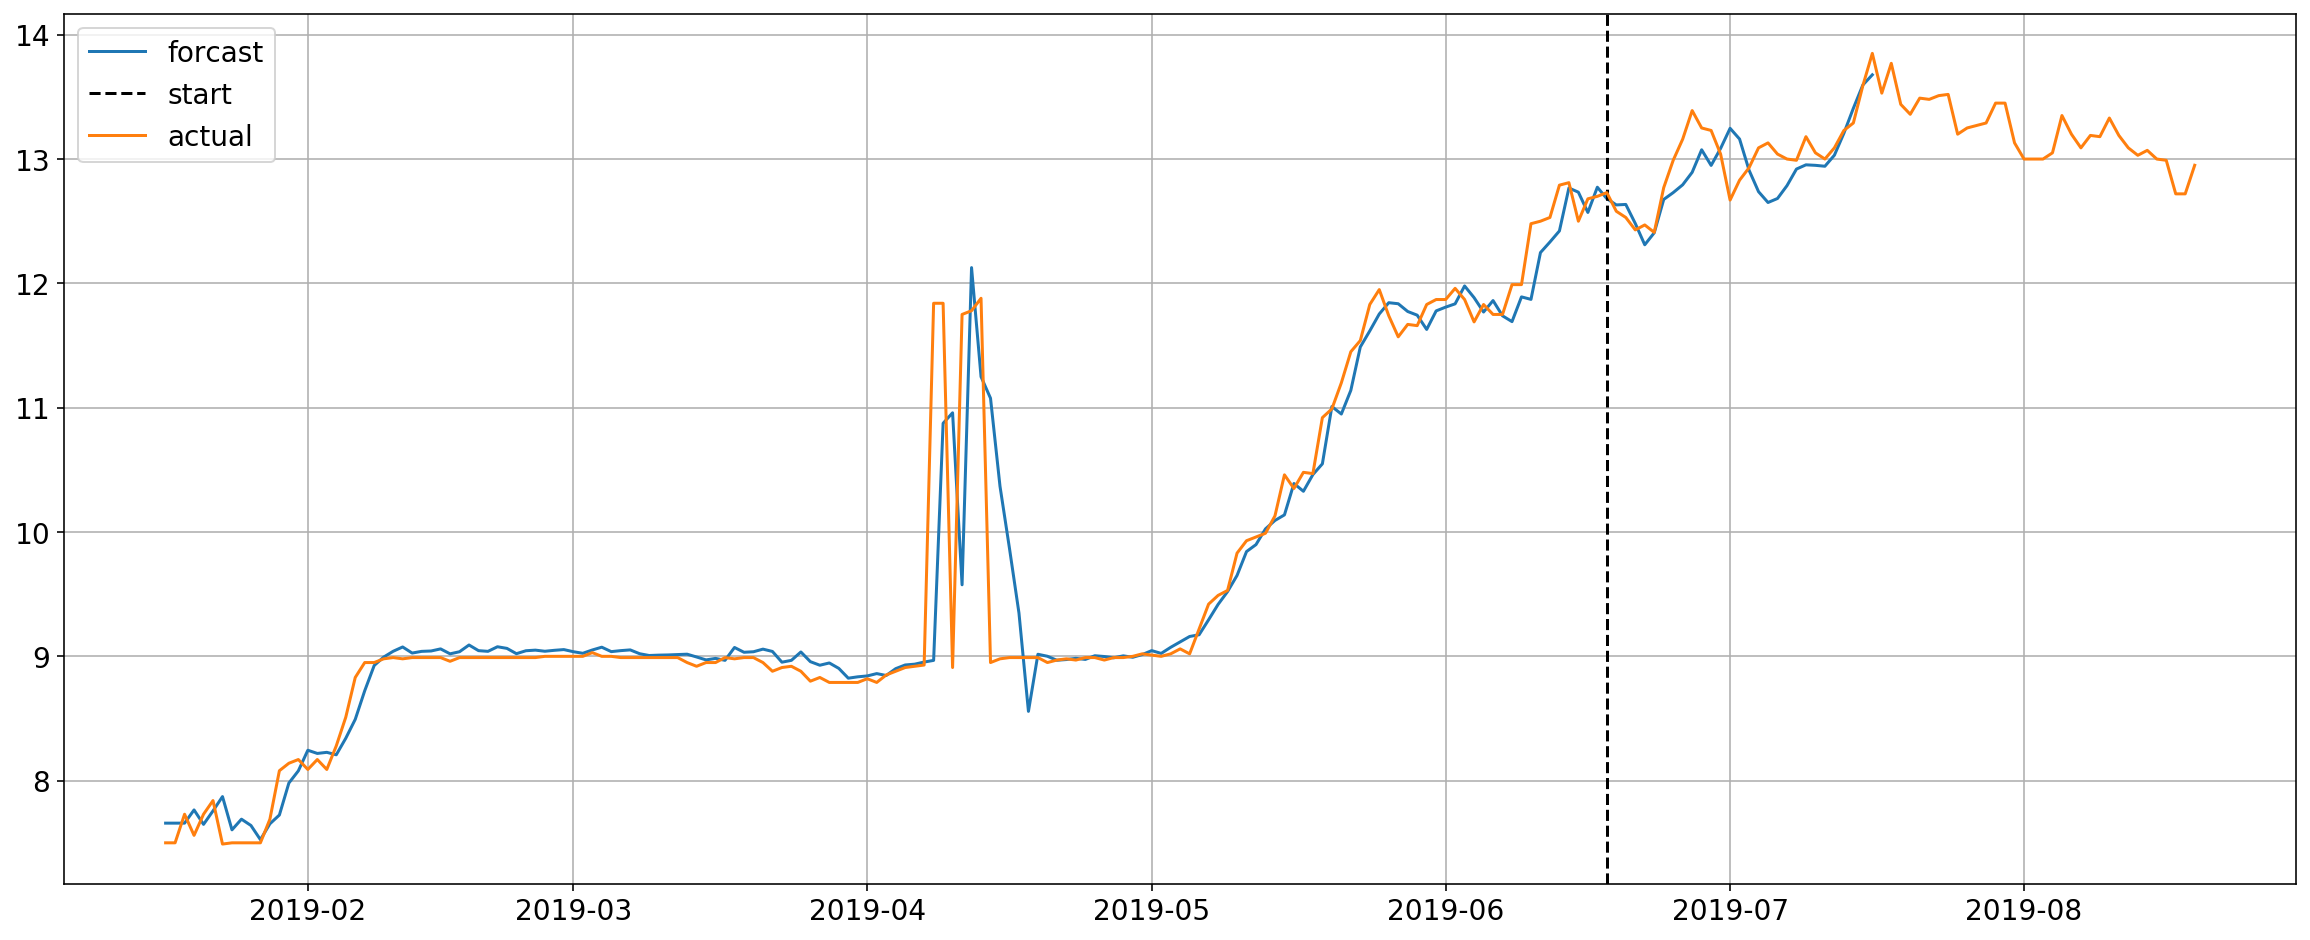

In [45]:
forcaster = Forcaster(forcast_len=28)
start_idx = '2019-06-18'
forcaster.fit(X[:start_idx],y[:start_idx])

preds = forcaster.forcast(X, start=start_idx)
plt.plot(y)
plt.legend(['forcast',
            'start',
            'actual']);

Boom, there is your forcast overlayed with the actual. Looks pretty good so far.

***This analysis is still in progress and is continuously being added too.***

I will explore these things later in the analysis:
 - Add Market Events
 - Retro Fit Modern Format data.
 - Feature optimization
 - Monte Carlo simulation with a portfolio
 - Stochastic Gradient Descent with combined card datasets
 - Live forcasting

/Users/chrisevans/Study/01_MachineLearning/env/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/chrisevans/Study/01_MachineLearning/env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


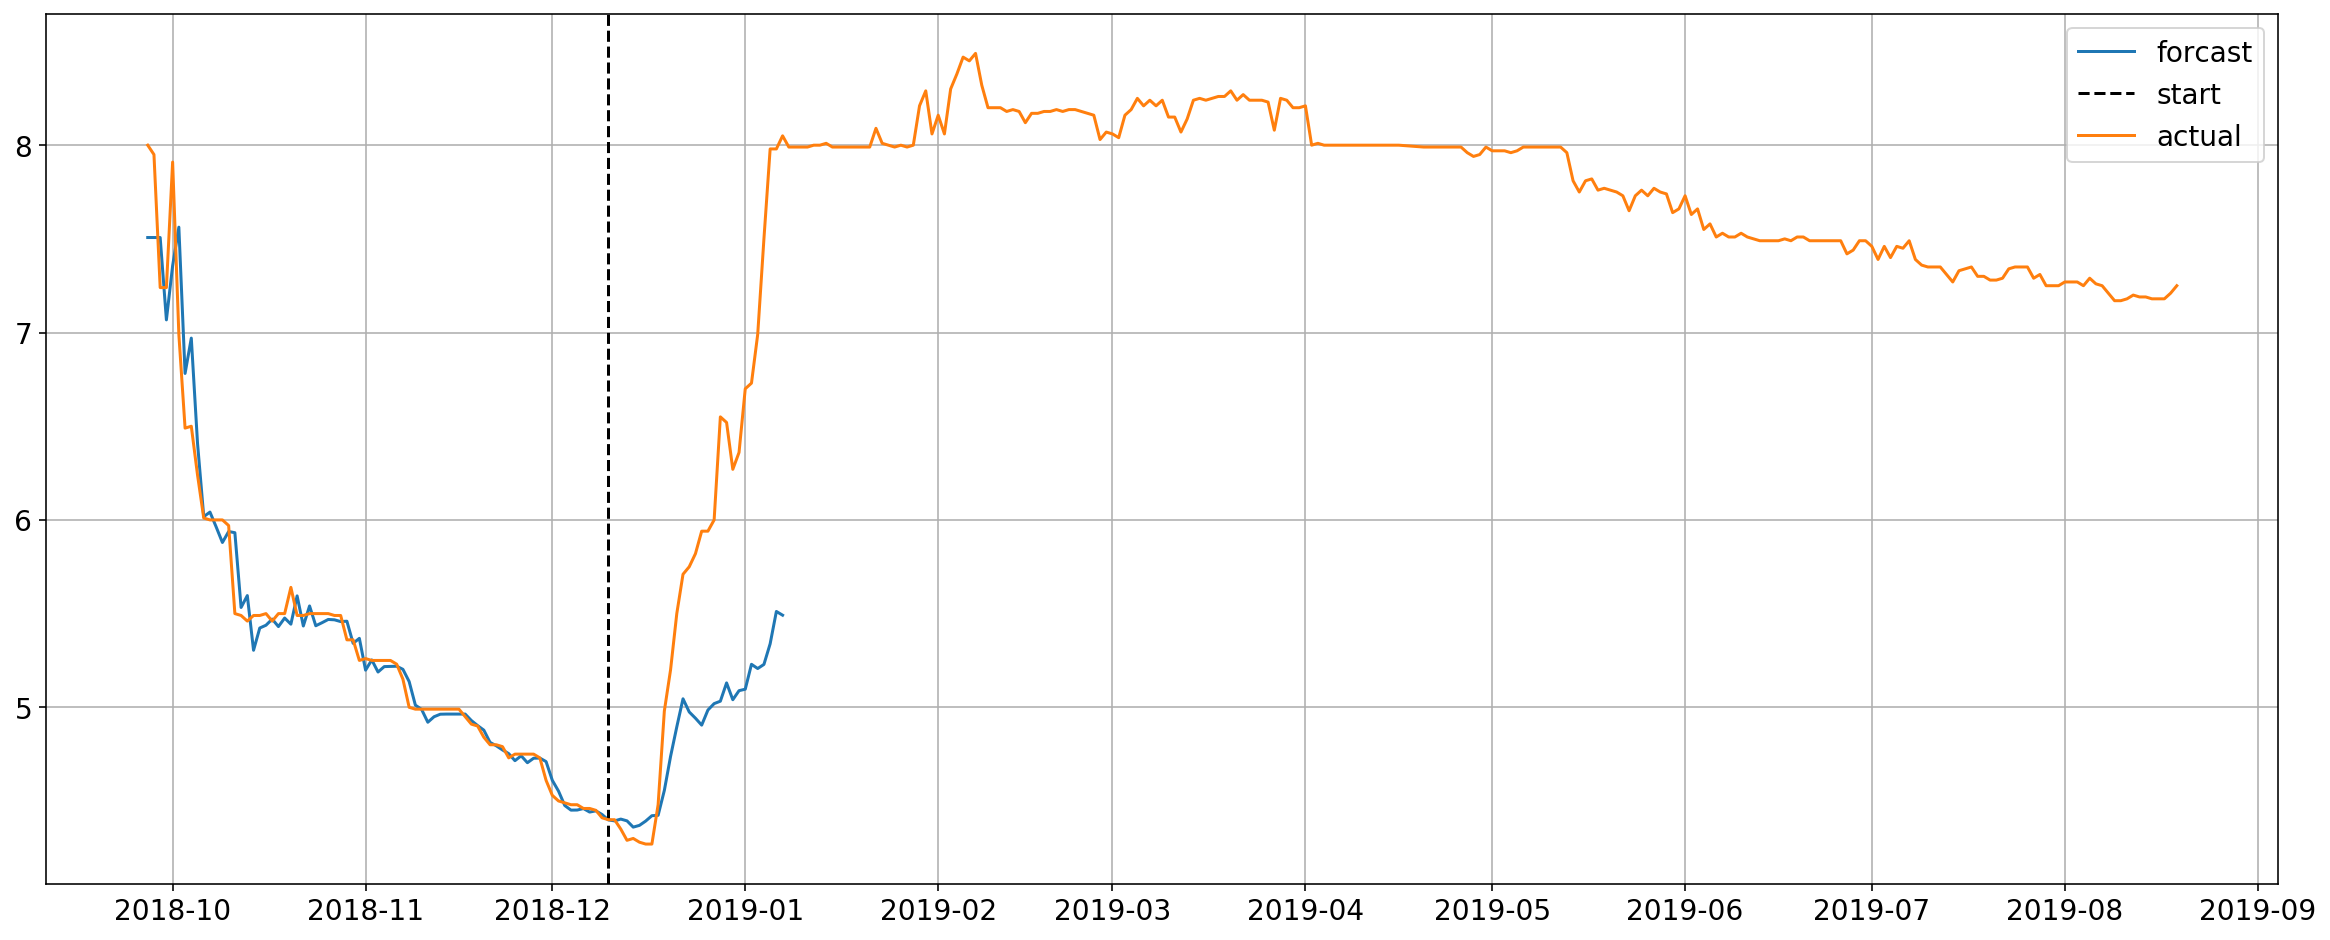

In [46]:
from sklearn.pipeline import Pipeline

path = './data/guilds-of-ravnica/divine-visitation/'

card = load_card_data(path).drop('date_unix', axis=1)
card_occurances = load_occurances_grouped_date(path)
card_occurances_raw = card_occurances[['datetime', 'raw_per_decks']]
table  = pd.merge(card,
                 card_occurances_raw[['datetime', 'raw_per_decks']],
                 on='datetime', 
                 how='left')
table.set_index('datetime', inplace=True)
tourny_dates = load_tournament_dates(path='./data/tournies_standard_aug19-oct17.json')
card_data = pd.merge(table, tourny_dates, how='left', right_index=True, left_index=True)

PrepPipe = Pipeline([
    ('tourny_imputer', TournamentImputer()),
    ('rolling_avg', RollingAverages(columns=['price_dollars', 'raw_per_decks'], windows=[5,5])),
    ('horizonizer', Horizonizer(columns = ['d_price_dollars', 'raw_per_decks'], windows=[5,5])),
    ('post_imputer', PostImputer())
])

table = PrepPipe.fit_transform(card_data)
X, y = table.copy().drop('price_dollars', axis=1), table['price_dollars']

forcaster = Forcaster(forcast_len=28)
start_idx = '2018-12-10'
forcaster.fit(X[:start_idx],y[:start_idx])

preds = forcaster.forcast(X, start=start_idx)
plt.plot(y)
plt.legend(['forcast',
            'start',
            'actual']);

/Users/chrisevans/Study/01_MachineLearning/env/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/chrisevans/Study/01_MachineLearning/env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


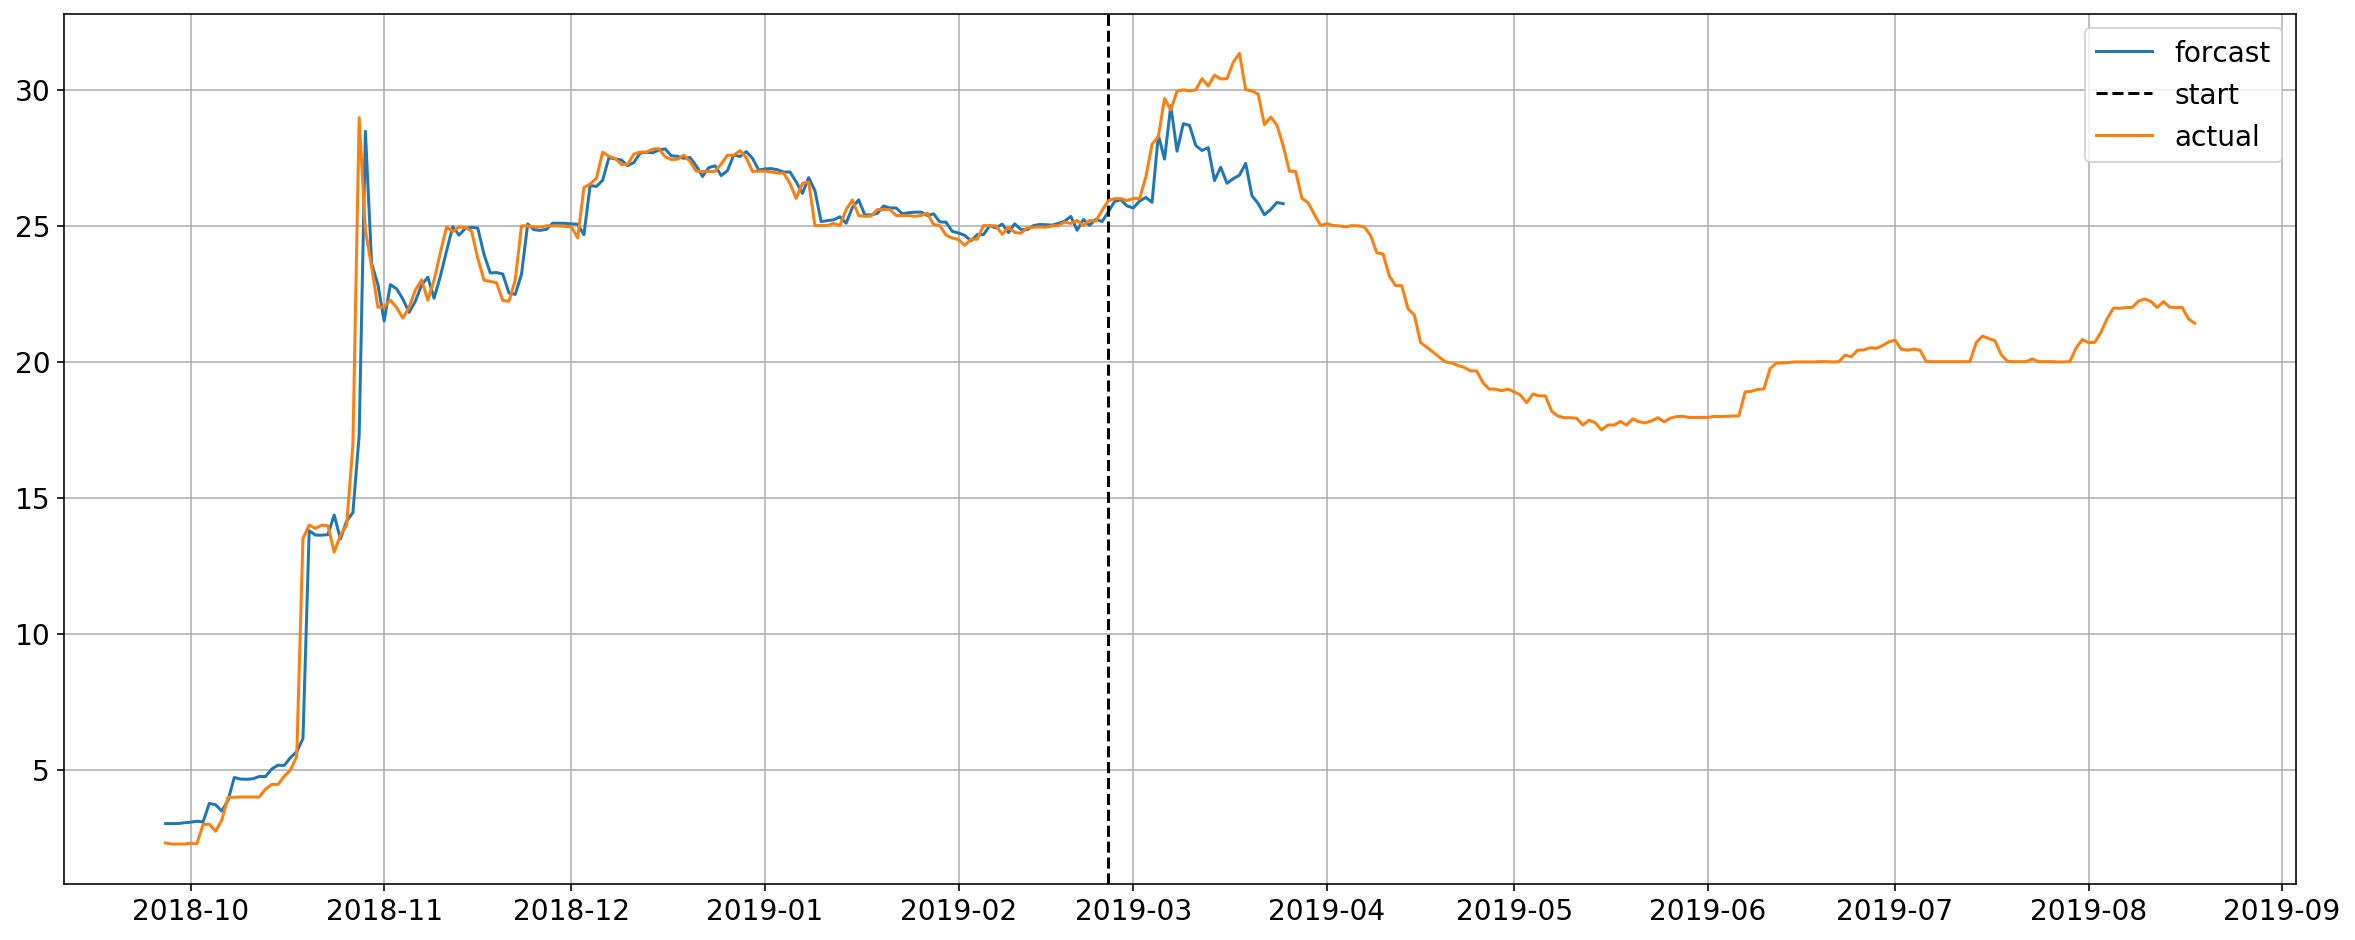

In [51]:
path = './data/guilds-of-ravnica/arclight-phoenix/'

card = load_card_data(path).drop('date_unix', axis=1)
card_occurances = load_occurances_grouped_date(path)
card_occurances_raw = card_occurances[['datetime', 'raw_per_decks']]
table  = pd.merge(card,
                 card_occurances_raw[['datetime', 'raw_per_decks']],
                 on='datetime', 
                 how='left')
table.set_index('datetime', inplace=True)
tourny_dates = load_tournament_dates(path='./data/tournies_standard_aug19-oct17.json')
card_data = pd.merge(table, tourny_dates, how='left', right_index=True, left_index=True)

PrepPipe = Pipeline([
    ('tourny_imputer', TournamentImputer()),
    ('rolling_avg', RollingAverages(columns=['price_dollars', 'raw_per_decks'], windows=[5,5])),
    ('horizonizer', Horizonizer(columns = ['d_price_dollars', 'raw_per_decks'], windows=[5,5])),
    ('post_imputer', PostImputer())
])

table = PrepPipe.fit_transform(card_data)
X, y = table.copy().drop('price_dollars', axis=1), table['price_dollars']

forcaster = Forcaster(forcast_len=28)
start_idx = '2019-02-25'
forcaster.fit(X[:start_idx],y[:start_idx])

preds = forcaster.forcast(X, start=start_idx)
plt.plot(y)
plt.legend(['forcast',
            'start',
            'actual']);